In [6]:
import pandas as pd
import json
from datetime import datetime
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def load_activity(file_path, source_name):
    with open(file_path, 'r') as f:
        data = json.load(f)

    records = []
    for entry in data:
        records.append({
            "time": entry.get("time"),
            "title": entry.get("title"),
            "url": entry.get("titleUrl", ""),
            "header": entry.get("header", ""),
            "source": source_name
        })
    return pd.DataFrame(records)

df_chrome = load_activity('../data/chrome_activity.json', 'Chrome')
df_youtube = load_activity('../data/youtube_activity.json', 'YouTube')
df_maps = load_activity('../data/maps_activity.json', 'Maps')

# Merge all
df = pd.concat([df_chrome, df_youtube, df_maps], ignore_index=True)
df['time'] = pd.to_datetime(df['time'], format='mixed', errors='coerce')
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.day_name()

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
# Create a new dataframe with daily activity counts
activity_by_day = df.groupby('date').size().reset_index(name='activity_count')
activity_by_day['weekday'] = pd.to_datetime(activity_by_day['date']).dt.dayofweek
activity_by_day['prev_day'] = activity_by_day['activity_count'].shift(1).fillna(0)
activity_by_day['prev_2day'] = activity_by_day['activity_count'].shift(2).fillna(0)

# Label: Was active on this day (1) or not (0)
activity_by_day['active'] = (activity_by_day['activity_count'] > 0).astype(int)

# Add some simulated inactive days (you can adjust as needed)
simulated_inactive_data = {
    'date': ['2025-07-01', '2025-07-02'],  # Simulate some dates with no activity
    'activity_count': [0, 0],  # No activity
    'weekday': [2, 3],  # Just as an example (e.g., Tuesday, Wednesday)
    'prev_day': [0, 0],
    'prev_2day': [0, 0],
    'active': [0, 0]  # Set as inactive
}
inactive_df = pd.DataFrame(simulated_inactive_data)
# Append to the activity_by_day dataframe
activity_by_day = pd.concat([activity_by_day, inactive_df])


# Prepare the features (X) and labels (y)
features = activity_by_day[['weekday', 'prev_day', 'prev_2day']]
labels = activity_by_day['active']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

joblib.dump(model, 'activity_predictor_model.pkl')
activity_by_day.to_pickle('activity_by_day.pkl')

# Predict and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")





Model Accuracy: 1.00


In [3]:
activity_by_day['active'].value_counts()

active
1    1690
Name: count, dtype: int64

In [ ]:
df.groupby('hour').size().plot(kind='bar')

In [5]:
df['header'].value_counts().head(10)

header
YouTube             82934
youtube.com          3299
Maps                  821
Chrome                806
google.com            289
github.com            115
chatgpt.com            87
netflix.com            87
hotstar.com            79
drive.google.com       52
Name: count, dtype: int64

<Axes: xlabel='weekday'>

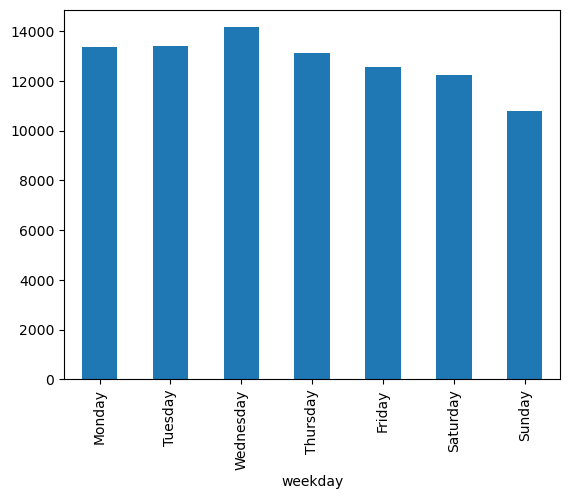

In [6]:
df.groupby('weekday').size().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar')


<Axes: ylabel='count'>

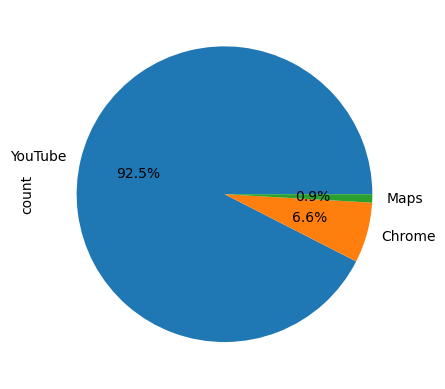

In [7]:
df['source'].value_counts().plot(kind='pie', autopct='%1.1f%%')
